# **HAVOK study** | scalability

*Ref*: [github@baronefr/rhavok-analysis](github.com/baronefr/rhavok-analysis)

> How does the HAVOK analysis scale wrt dataset size and rank choice?

In [1]:
import rhavok
from rhavok.havok import havok

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import itertools
from tqdm.notebook import tqdm
import multiprocessing 
import sys
import os

In [2]:
dataset_file = './data/attractors/Lorenz_ext3000.npy'

In [3]:
rhavok.__version__

'0.1.4'

#### Data import

We import the Lorenz attractor data. This ODE solution has been generated using the parameters
$\sigma = 10$, $\beta = 8/3$ and $\rho = 28$, with initial condition $x_0 = \left[ -8, 8, 27\right]$. The data is sampled with time step $dt=0.001$ using an ode45 solver.

In [4]:
# load data from Lorenz attractor
xxn, yyn, zzn = np.load(dataset_file)
dt = 0.001
ttn = dt*np.arange(len(xxn))

<br>

### Parameters to probe

In [5]:
train_times = [5, 20, 50, 100, 200, 400]
ranks = [8,11,15,20]
H_shapes = [20, 50, 100]

test_size = 1000

In [6]:
comb = list(itertools.product(train_times,ranks,H_shapes))
n = len(comb)
print(f'{n} combinations to test')

72 combinations to test


In [7]:
df = pd.DataFrame({'train_time': pd.Series(dtype='int'),
                   'rank': pd.Series(dtype='int'),
                   'delay_size': pd.Series(dtype='int'),
                   'mowin1': object,
                   'havok1': object,
                   'dynA': object,
                   'dynB': object})

In [8]:
df.dtypes

train_time     int64
rank           int64
delay_size     int64
mowin1        object
havok1        object
dynA          object
dynB          object
dtype: object

<br><br>

#### Havok workflow

In [9]:
def workflow_havok_wrapper(params):
    train_time, rank, delay = params
    lorh = havok(dataset = xxn, dt = dt, timing = ttn, time_delay_size = delay, crop = int((train_time+test_size)/dt),
                 train_size = int(train_time/dt), rank = rank)
    
    lorh.workflow()
    #lorh.show_regression().show()
    
    vhavok, thavok = lorh.simulate_system(init = 'test')
    #lorh.plot_simulation(900, 1000).show() # end of dataset
    
    v1_mw = lorh.test_mowin[:,0]
    v1_havok = vhavok[:,0]
    
    l2100 = np.linalg.norm(v1_mw[:100000] - v1_havok[:100000], ord=2)  
    l1err = np.linalg.norm(v1_mw - v1_havok, ord=1)  
    l2err = np.linalg.norm(v1_mw - v1_havok, ord=2)    
    return v1_mw, v1_havok, lorh.regr[0], lorh.regr[1]

In [10]:
# utility to mute stdout
def mute(): sys.stdout = open(os.devnull, 'w')

In [11]:
# serial version
#for idx, cc in enumerate(tqdm(comb)):
#    with mute(): c = workflow_havok_wrapper(cc)
#    df.loc[idx] = comb[idx] + tuple(c)

In [12]:
p = multiprocessing.Pool(initializer=mute)
results = tqdm(p.imap(workflow_havok_wrapper, comb), total=n)

sys.stderr = open(os.devnull, 'w')  # suppress warning
for i, c in enumerate(results):
    df.loc[i] = comb[i] + tuple(c)

  0%|          | 0/72 [00:00<?, ?it/s]

In [13]:
df.head(2)

,train_time,rank,delay_size,mowin1,havok1,dynA,dynB
0,5,8,20,"[-0.02316229449499667, -0.02307380509152229, -...","[-0.02350125941375099, -0.02341881415023793, -...","[[0.1992079764337007, -5.622932099971051, -0.0...","[[3.1187659496657817e-09], [1.1035793684011018..."
1,5,8,50,"[-0.02432867130822202, -0.02426550233467418, -...","[-0.024563746952808715, -0.024507647707713395,...","[[0.25991438734764055, -5.527155727313861, 0.0...","[[-6.386996070419198e-07], [-1.492649295329403..."


In [14]:
def calc_stats(row):
    tmp = row.mowin1 - row.havok1 
    l2100 = np.linalg.norm(tmp[:100000], ord=2)  
    l1err = np.linalg.norm(tmp, ord=1)  
    l2err = np.linalg.norm(tmp, ord=2)  
    return pd.Series([l2100, l1err, l2err])

df[['L2_100s','L1','L2']] = df.apply(calc_stats, axis=1)

<br>

#### Visualize HAVOK simulation

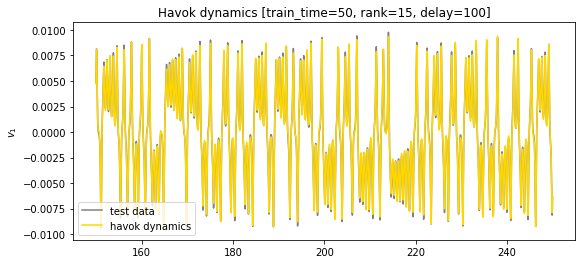

In [15]:
# a function to easily get an havok trained obj
def get_havok(trs, rnk, des):
    return df.query('train_time==@trs and rank==@rnk and delay_size==@des', engine='python')

def dynamics(idx, time = [0,100], delta = False, figsize=(9,4), deltaf = lambda x: x):
    
    if isinstance(idx, dict): idx = (idx['train'], idx['rank'], idx['delay'])
    
    this = get_havok(*idx) # get the correct values
    train_time = this.train_time.values[0]
    # parse timing arg
    first_idx = int(time[0]/dt)
    time = np.arange(train_time + time[0], train_time + time[1], dt)
    timeidx = range(first_idx, len(time) + first_idx )
    mowin = this.mowin1.values[0][timeidx]
    havok = this.havok1.values[0][timeidx]
    
    # plotting
    if delta: fig, (ax1, ax2) = plt.subplots(2,1,figsize=(figsize[0], figsize[1]*2))
    else:     fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(time, mowin, color='grey', label='test data')
    ax1.plot(time, havok, color='gold', label='havok dynamics')
    ax1.set_ylabel(r"$v_1$")
    if delta:
        #ax2 = ax1.twinx()
        ax2.set_ylabel(r'$\Delta v_1$')
        ax2.plot(time, deltaf(mowin-havok), color='navy', label=r'$\Delta$')
        ax2.legend()
        
    ax1.set_title("Havok dynamics [train_time={}, rank={}, delay={}]".format(*idx) )
    ax1.legend()
    return fig

dynamics( (50, 15, 100), time = [100, 200] ).show()
#dynamics( (200, 8, 20), time = [20, 30], delta = True ).show()

<br><br>

## **Errors in dynamic simulation**

In [16]:
rr = 8
print(f' >>>>> rank = {rr} <<<<<')
pd.pivot_table(df[df['rank'] == rr], columns=['train_time','delay_size'], values=['L2_100s','L1','L2'])

 >>>>> rank = 8 <<<<<


train_time           5                                20              \
delay_size           20         50          100       20         50    
L1          9.958009e+29  62.120937  199.315214  5.653743  31.169727   
L2          5.789670e+27   0.078954    0.245467  0.007649   0.038427   
L2_100s     2.174588e+01   0.030524    0.075656  0.004520   0.012687   

train_time                   50                              100             \
delay_size         100       20         50         100       20         50    
L1          118.527182  5.209786  25.001492  94.873870  5.616357  27.751203   
L2            0.144477  0.008406   0.031246   0.117584  0.010586   0.035229   
L2_100s       0.046340  0.006908   0.011664   0.040786  0.009223   0.016250   

train_time                  200                             400             \
delay_size        100       20         50         100       20         50    
L1          93.436615  5.857330  25.160485  83.465608  6.440458  26.536657   
L2           0.116657  0.008304   0.031919   0.103498  0.009614   0.033590   
L2_100s      0.042628  0.005647   0.010723   0.032509  0.007337   0.010395   

train_time             
delay_size        100  
L1          81.911728  
L2           0.101808  
L2_100s      0.029545

In [17]:
rr = 15
print(f' >>>>> rank = {rr} <<<<<')
pd.pivot_table(df[df['rank'] == rr], columns=['train_time','delay_size'], values=['L2_100s','L1','L2'])

 >>>>> rank = 15 <<<<<


train_time           5                                      20                \
delay_size           20            50          100          20           50    
L1          10143.949455  4.400003e+17  285.252894  3411.162648  5788.406725   
L2             12.354160  1.885593e+15    0.348728     4.177617     7.065321   
L2_100s         4.009581  1.302502e+01    0.110924     1.324128     2.247357   

train_time                      50                                    100  \
delay_size         100          20           50          100          20    
L1          402.622472  2456.789084  3921.381526  268.140603  1732.576358   
L2            0.525145     3.012584     4.822231    0.312250     2.121631   
L2_100s       0.111090     0.971431     1.662190    0.067313     0.710938   

train_time                                   200                           \
delay_size          50          100          20            50         100   
L1          2971.661392  638.321579  1167.350055  1.416430e+06  95.848345   
L2             3.643020    0.785992     1.433901  3.625483e+03   0.116643   
L2_100s        1.251700    0.070906     0.521377  1.962930e+00   0.028556   

train_time         400                            
delay_size         20            50          100  
L1          863.886985  1.030455e+19  421.833114  
L2            1.064968  4.987309e+16    0.551074  
L2_100s       0.417032  6.573681e+01    0.151880

<br>

### error wrt train size

L2 error for different ranked models, fixed delay_size = 100


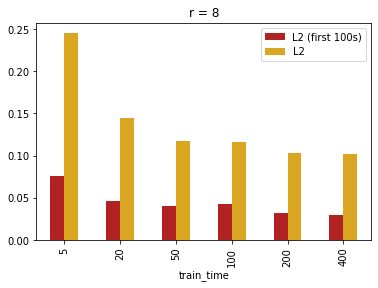

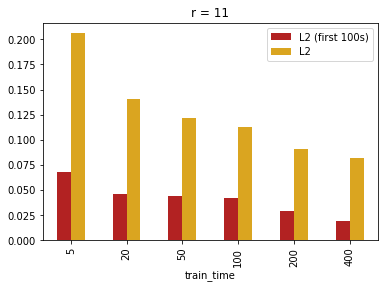

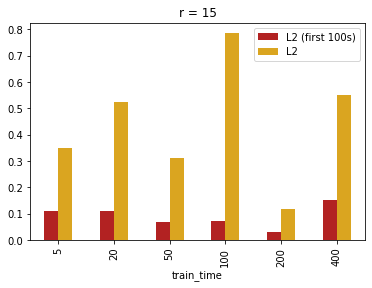

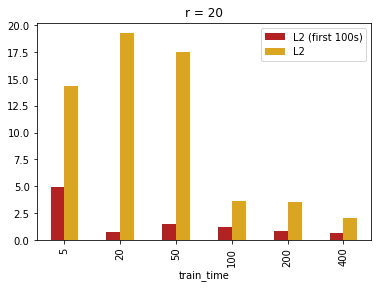

In [18]:
print('L2 error for different ranked models, fixed delay_size = 100')
for rank, group in df[df['delay_size'] == 100].groupby('rank'):
    group.plot(kind='bar', x='train_time', y=['L2_100s','L2'], title=r'r = '+str(rank), color=['firebrick','goldenrod'])
    L=plt.legend()
    L.get_texts()[0].set_text('L2 (first 100s)')

<br>

### **error wrt delay_size**

L2 error for different ranked models, fixed train_time = 100


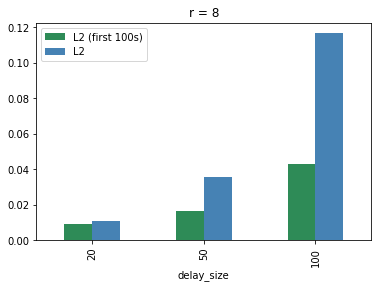

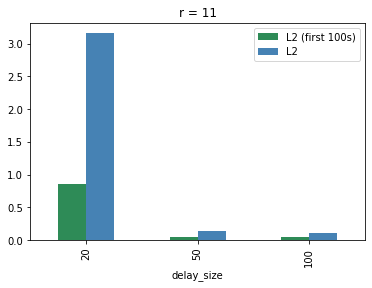

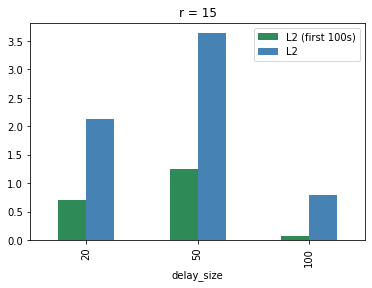

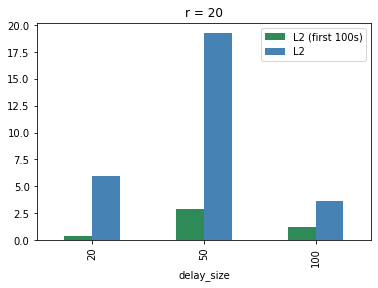

In [19]:
print('L2 error for different ranked models, fixed train_time = 100')
for rank, group in df[df['train_time'] == 100].groupby('rank'):
    group.plot(kind='bar', x='delay_size', y=['L2_100s','L2'], title=r'r = '+str(rank), color=['seagreen','steelblue'])
    L = plt.legend()
    L.get_texts()[0].set_text('L2 (first 100s)')

#### **some critical examples**

<br>

- **small train datasets** with **small delay window** have bad results already in the first 100 seconds of test data, regardless of the rank

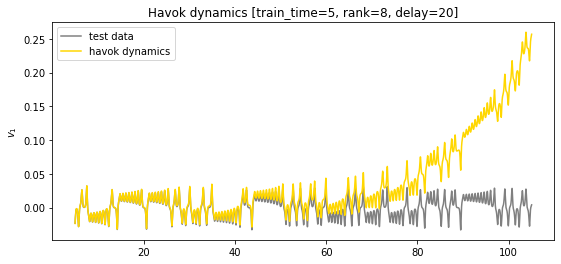

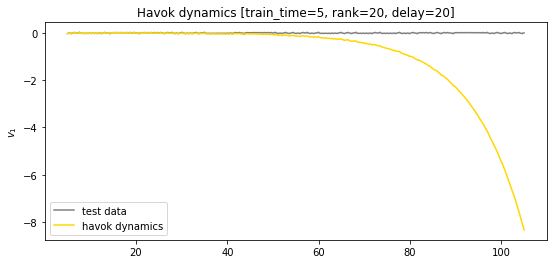

In [20]:
dynamics( {'train':5, 'rank':8, 'delay':20} ).show()
dynamics( {'train':5, 'rank':20, 'delay':20} ).show()

<br>

- with **small train datasets**, using **bigger delay window** improves the error, but only if the rank is not elevated

this seems fine, in the whole dataset...


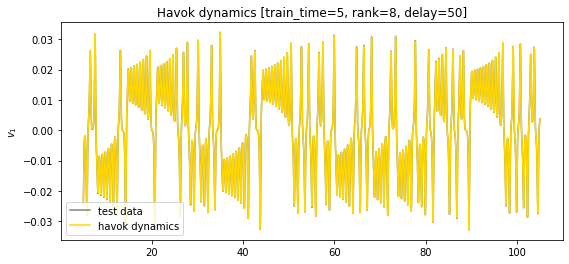

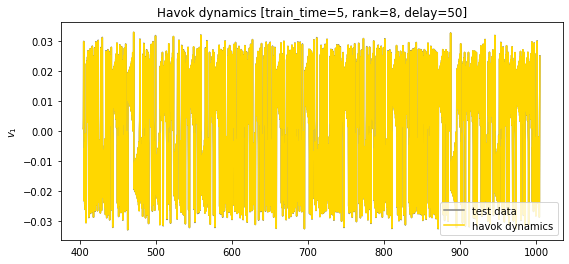

In [21]:
print('this seems fine, in the whole dataset...')
dynamics( {'train':5, 'rank':8, 'delay':50} ).show()
dynamics( {'train':5, 'rank':8, 'delay':50}, time = [400, 1000] ).show()

... but these go off right at the beginning


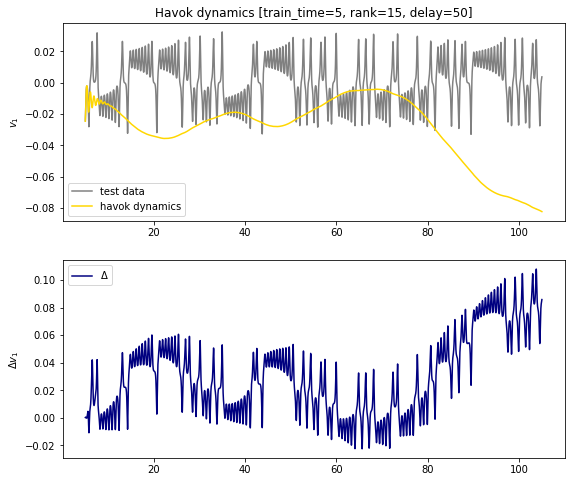

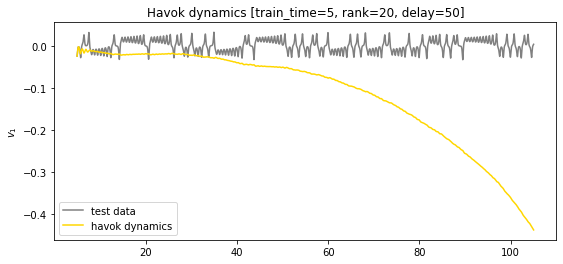

In [22]:
print('... but these go off right at the beginning')
dynamics( {'train':5, 'rank':15, 'delay':50}, delta = True ).show()
dynamics( {'train':5, 'rank':20, 'delay':50}).show()

<br>

- even with large training datasets, **it is crucial to have a bigger delay window**, expecially for higher rank models

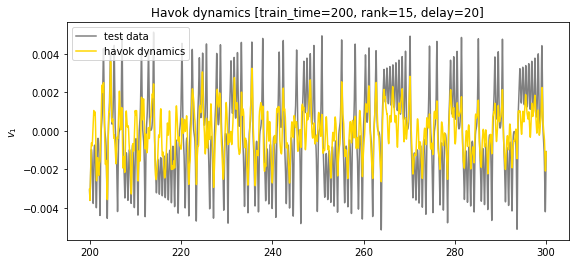

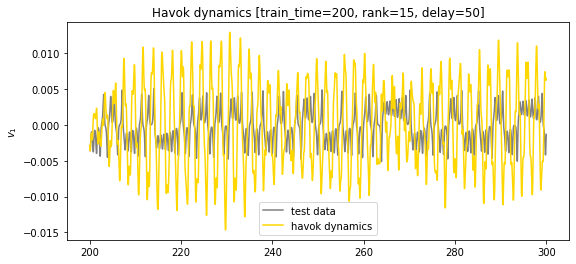

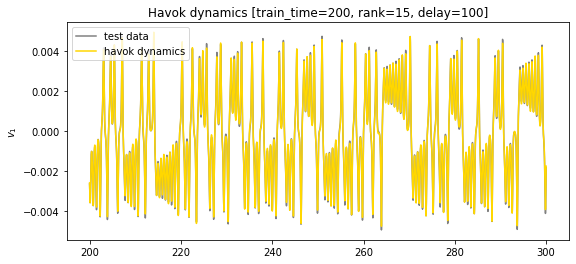

In [23]:
dynamics( {'train':200, 'rank':15, 'delay':20} ).show()
dynamics( {'train':200, 'rank':15, 'delay':50} ).show()
dynamics( {'train':200, 'rank':15, 'delay':100} ).show()

This is a low rank model instead, it seems fine!


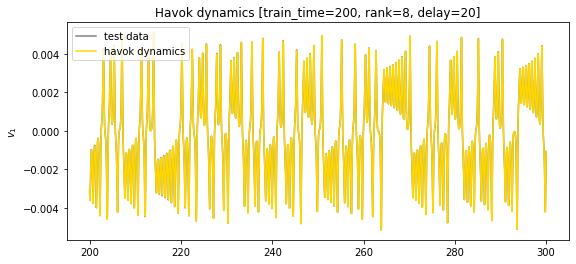

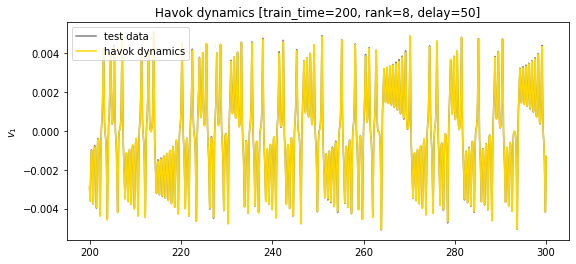

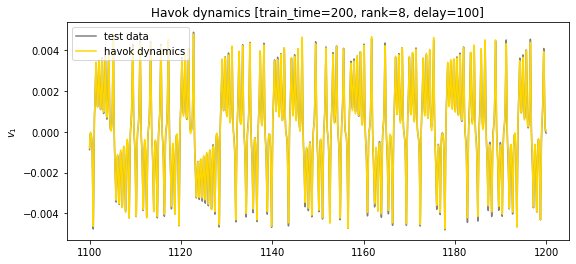

In [24]:
print('This is a low rank model instead, it seems fine!')
dynamics( {'train':200, 'rank':8, 'delay':20} ).show()
dynamics( {'train':200, 'rank':8, 'delay':50} ).show()
dynamics( {'train':200, 'rank':8, 'delay':100} , time = [900, 1000]).show()

<br><br>

## **Pattern variation in linear model matrices**

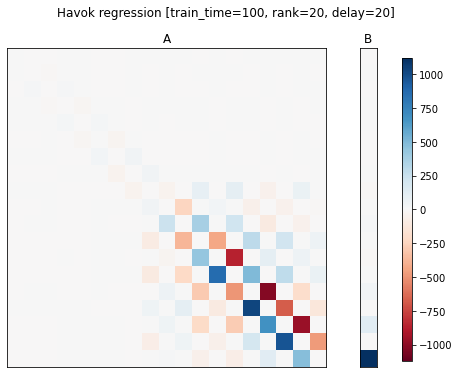

In [25]:
def regression(idx):
    if isinstance(idx, dict): idx = (idx['train'], idx['rank'], idx['delay'])
    this = get_havok(*idx) # get the associated values
    
    A, B = this.dynA.values[0], this.dynB.values[0]
    
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [14, 1 if idx[1] < 16 else 0.737 ]}, figsize=(7,6))
    fig.tight_layout()                         # fix overflow for large ranks ^^^^^^^^^^^^^^^^
    
    color_limit = max( np.ceil(np.abs(A).max()), np.ceil(np.abs(B).max()) )
    
    im = ax[0].imshow(A, cmap='RdBu', interpolation='nearest', aspect='equal', 
                      vmin=-color_limit, vmax=color_limit)
    ax[0].set(title='A')
    plt.setp(ax[0].get_xticklabels(), visible=False)
    plt.setp(ax[0].get_yticklabels(), visible=False)
    ax[0].tick_params(axis='both', which='both', length=0)
     
    ax[1].imshow(B, cmap='RdBu', interpolation='nearest', aspect='equal', 
                 vmin=-color_limit, vmax=color_limit)
    ax[1].set(title='B')
    plt.setp(ax[1].get_xticklabels(), visible=False)
    plt.setp(ax[1].get_yticklabels(), visible=False)
    ax[1].tick_params(axis='both', which='both', length=0)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.16, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle("Havok regression [train_time={}, rank={}, delay={}]".format(*idx) )
    return fig

def regression_matrix(idx):
    if isinstance(idx, dict): idx = (idx['train'], idx['rank'], idx['delay'])
    this = get_havok(*idx) # get the associated values
    
    A, B = this.dynA.values[0], this.dynB.values[0]
    return pd.DataFrame(A)

regression( { 'train':100, 'rank':20, 'delay':20} ).show()
#regression( { 'train':200, 'rank':15, 'delay':100}  ).show()
#regression_matrix( { 'train':200, 'rank':15, 'delay':100}  )

<br><br>

### examples

- the **train dataset size** does not change significantly the pattern of regression, but it typically makes the matrix **sparser**

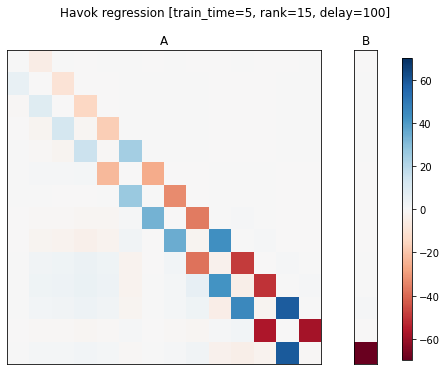

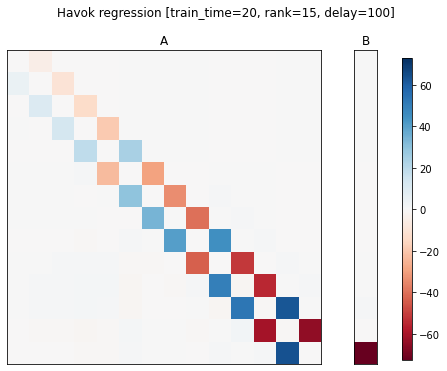

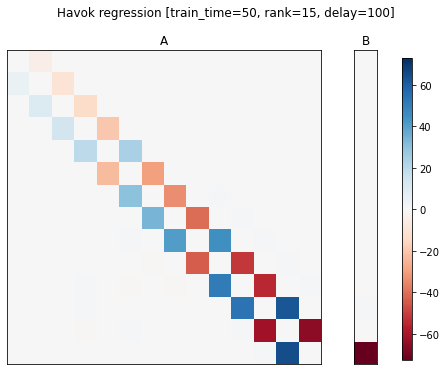

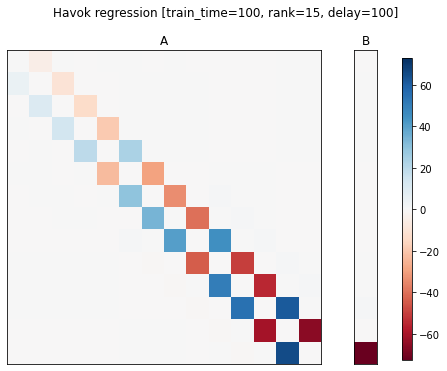

In [26]:
regression( { 'train':5, 'rank':15, 'delay':100} ).show()
regression( { 'train':20, 'rank':15, 'delay':100} ).show()
regression( { 'train':50, 'rank':15, 'delay':100} ).show()
regression( { 'train':100, 'rank':15, 'delay':100} ).show()

In [27]:
regression_matrix( { 'train':5, 'rank':15, 'delay':100} )

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.306468,-5.344653,0.009519,-0.128115,0.000197,0.002191,-0.000004,0.000034,-4.249434e-08,-5.584535e-07,4.139370e-10,-9.275797e-09,-1.704104e-11,1.481431e-10
1,5.309360,-0.483501,-9.643121,-0.026881,-0.178697,0.000251,0.002918,0.000004,4.765656e-05,-1.065560e-07,-8.202421e-07,-1.447360e-09,1.351761e-08,1.860469e-11
2,-0.744926,8.323283,-0.516255,-14.649668,-0.016365,0.246936,0.000154,0.003876,5.559951e-06,-6.277960e-05,-1.309620e-07,-1.041146e-06,1.007700e-09,1.660708e-08
3,-0.013347,-1.665708,12.428592,-1.476197,-17.294012,0.029434,0.278830,0.000436,4.544306e-03,-1.153031e-05,-7.801798e-05,-1.597584e-07,1.282637e-06,2.116592e-09
4,0.247996,-1.018196,-1.943836,15.161159,-0.671359,23.980036,0.010323,0.370004,4.558233e-04,-5.972161e-03,-1.108450e-05,-9.868362e-05,7.245323e-08,1.569200e-06
5,0.244433,0.928981,0.783367,1.569392,-22.728869,-0.409591,-25.802555,-0.010022,-4.136817e-01,5.623501e-04,7.067937e-03,6.361934e-06,-1.156577e-04,-6.228486e-08
6,0.259622,0.017595,-0.261753,-0.276519,0.138013,25.872646,0.054434,-33.171918,-2.338178e-02,5.246169e-01,6.780527e-04,8.615107e-03,-1.487062e-06,-1.362131e-04
7,-0.221966,-0.802869,-0.884107,-1.380769,-1.455376,0.715040,33.108059,-0.302875,-3.642334e+01,4.381398e-02,6.097513e-01,4.649237e-04,-9.901217e-03,-4.050778e-06
8,-0.436866,-1.998535,-2.320504,-3.455540,-2.647124,2.208289,-0.087248,34.878707,-1.957088e+00,4.290607e+01,8.630792e-02,6.889650e-01,-6.438579e-04,-1.079305e-02
9,0.275479,2.455762,3.143957,4.274511,3.133983,-2.296198,-0.498676,1.936427,-3.794120e+01,-3.090068e+00,-4.885273e+01,-7.698044e-02,7.738953e-01,9.492889e-04


In [28]:
regression_matrix( { 'train':200, 'rank':15, 'delay':100} )

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.003185,-5.119859,-0.000019,-0.118131,-3.553758e-07,0.002163,-4.170362e-08,3.876303e-05,-4.548083e-10,-7.010009e-07,-1.926274e-11,-1.291222e-08,4.056918e-13,2.423781e-10
1,5.110331,-0.010256,-9.931780,-0.000744,-1.874735e-01,0.000009,3.351560e-03,8.251547e-08,6.007370e-05,-2.641846e-09,-1.095136e-06,-8.049685e-11,2.037129e-08,1.085833e-12
2,-0.000454,9.896883,-0.018213,-13.589024,-6.867876e-04,0.245187,6.984990e-06,4.389097e-03,1.579537e-07,-7.926178e-05,-5.980217e-09,-1.457838e-06,1.162605e-10,2.733243e-08
3,0.109853,-0.049511,13.525491,-0.051048,-1.893082e+01,0.001370,3.328770e-01,1.686496e-05,5.953439e-03,-4.167860e-07,-1.082606e-04,-1.076215e-08,2.009038e-06,1.567505e-10
4,-0.006896,0.147663,-0.050136,18.849466,-3.240306e-02,23.280955,6.325811e-04,4.096709e-01,1.435174e-05,-7.373094e-03,-5.455425e-07,-1.351221e-04,1.053371e-08,2.525487e-06
5,0.001979,0.046682,-0.191333,0.088532,-2.320919e+01,-0.038878,-2.894379e+01,-6.955044e-04,-5.076677e-01,2.193873e-05,9.188148e-03,6.587286e-07,-1.697073e-04,-8.471413e-09
6,0.004921,0.010632,0.021487,-0.300817,2.481266e-02,28.914529,-4.648443e-03,-3.355937e+01,-4.017156e-04,5.915548e-01,2.967987e-05,1.077443e-02,-5.745322e-07,-2.002345e-04
7,-0.001293,0.006814,0.000761,0.010507,-4.011964e-01,-0.007624,3.355538e+01,-2.202589e-04,-3.929734e+01,7.171884e-04,6.948998e-01,3.195772e-05,-1.273704e-02,-2.984665e-07
8,-0.003053,-0.036072,-0.041331,-0.075099,-5.522007e-02,0.567420,2.296573e-02,3.930372e+01,-2.294380e-02,4.402535e+01,2.414918e-03,7.821127e-01,-4.592194e-05,-1.440231e-02
9,0.007685,0.050112,0.062600,0.101013,8.788243e-02,-0.088750,-6.234513e-01,-1.099450e-02,-4.395714e+01,-4.994222e-02,-4.989626e+01,-3.033743e-03,8.896967e-01,3.538698e-05


<Figure size 720x504 with 0 Axes>

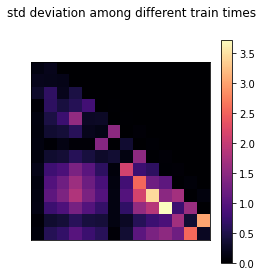

In [29]:
plt.figure(figsize=(10,7))
coll = [ regression_matrix( { 'train':tt, 'rank':15, 'delay':100} ) for tt in train_times ]
plt.matshow( np.std(coll, axis=0, ddof=1), cmap='magma')
plt.colorbar()
plt.suptitle('std deviation among different train times')
plt.xticks([]); plt.yticks([]);
plt.show()

<Figure size 720x504 with 0 Axes>

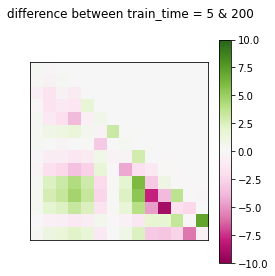

In [30]:
plt.figure(figsize=(10,7));
dev = regression_matrix( { 'train':5, 'rank':15, 'delay':100} ) - regression_matrix( { 'train':200, 'rank':15, 'delay':100} );
plt.matshow( dev, cmap='PiYG', vmin = -10, vmax = 10);
plt.colorbar();
plt.suptitle('difference between train_time = 5 & 200');
plt.xticks([]); plt.yticks([]);
plt.show();

<br>

- there are significant variations if we change the model **rank**

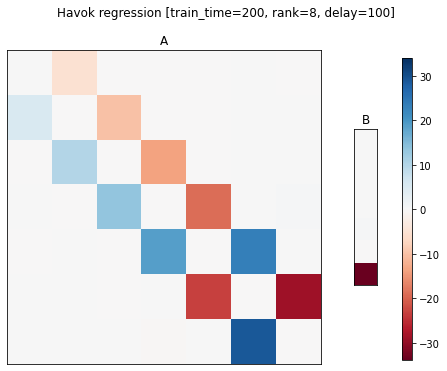

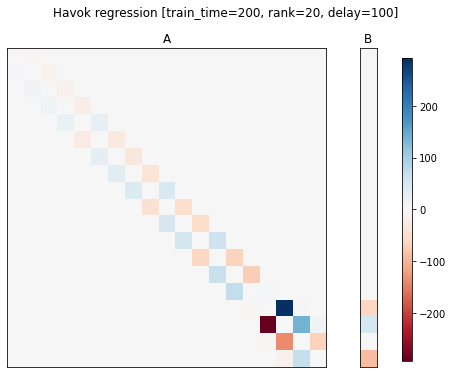

In [31]:
regression( { 'train':200, 'rank':8, 'delay':100} ).show()
regression( { 'train':200, 'rank':20, 'delay':100} ).show()

<br>

- there are significant variations if we change the **delay window size**

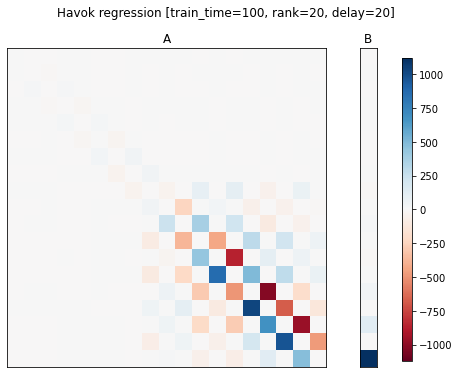

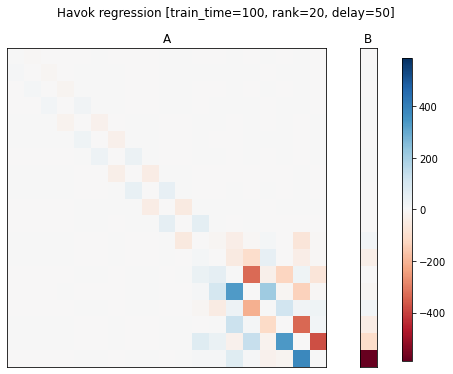

In [32]:
regression( { 'train':100, 'rank':20, 'delay':20} ).show()
regression( { 'train':100, 'rank':20, 'delay':50} ).show()

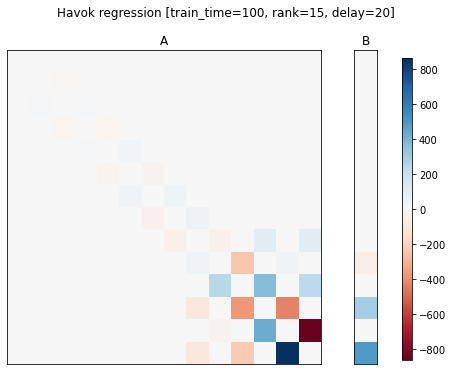

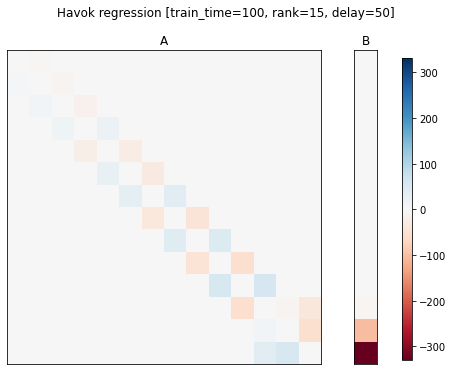

In [33]:
regression( { 'train':100, 'rank':15, 'delay':20} ).show()
regression( { 'train':100, 'rank':15, 'delay':50} ).show()

***

Code by *Francesco Barone*, last review: 04 Jun 2022. <br>**Workgroup**: Barone Francesco, Nagaro Gianmarco, Ninni Daniele, Valentini Lorenzo.

University of Padua, **Laboratory of Computational Physics**, module B.